# Model training

In [157]:
import torch
from torch import nn
import pandas as pd

In [158]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [159]:
# Load data

X_train = pd.read_csv("./../data/features/in_features_train.csv")
X_train_pca = pd.read_csv("./../data/features/pca_in_features_train.csv")

X_train.shape, X_train_pca.shape

((145, 2593), (145, 61))

In [160]:
y_train = pd.read_csv("./../data/features/out_features_train.csv").label
y_train_pca = pd.read_csv("./../data/features/pca_out_features_train.csv").label

y_train.shape, y_train_pca.shape

((145,), (145,))

In [161]:
X_test = pd.read_csv("./../data/features/in_features_test.csv")
X_test_pca = pd.read_csv("./../data/features/pca_in_features_test.csv")

X_test.shape, X_test_pca.shape

((16, 2593), (16, 61))

In [162]:
y_test = pd.read_csv("./../data/features/out_features_test.csv").label

y_test.shape

(16,)

## Support Vector Machine (SVM)

### Non PCA features

In [163]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold

svm = SVC(kernel='rbf', C=10, gamma=0.01)
# p_grid = {"C": [1, 10, 20, 50, 100], "gamma": [0.01, 0.1, 0.2, 0.4, 0.6, 0.8]}
# cv = KFold(n_splits=5, shuffle=True)

# clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=cv, scoring="f1_macro")
# clf.fit(X_train, y_train)

clf = svm.fit(X_train, y_train)

In [164]:
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 0, 0, 2, 0, 0, 2, 1, 2, 0, 0, 1, 0, 0, 0], dtype=int64)

In [165]:
y_test.to_numpy()

array([2, 2, 0, 0, 0, 2, 0, 1, 3, 1, 2, 0, 1, 0, 0, 0], dtype=int64)

In [166]:
from modules.engine import get_metrics
svm_train_metrics = get_metrics(y_train, clf.predict(X_train))

Accuracy:  0.8689655172413793  | F1-score:  0.8692980296196385  | Precision:  0.8928321678321678  | Recall:  0.8689655172413794


In [167]:
# Evaluate
svm_test_metrics = get_metrics(y_test, y_pred)

Accuracy:  0.5  | F1-score:  0.28421052631578947  | Precision:  0.28409090909090906  | Recall:  0.3020833333333333


In [168]:
clf.get_params()

{'C': 10,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.01,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [169]:
import joblib
from pathlib import Path


# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "svm.pk"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

joblib.dump(clf, MODEL_SAVE_PATH)

['models\\svm.pk']

### PCA features


In [170]:
svm = SVC(kernel='rbf', C=20, gamma=0.01)
# p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}
# cv = KFold(n_splits=5, shuffle=True)

# clf_pca = GridSearchCV(estimator=svm, param_grid=p_grid, cv=cv, scoring="f1_macro")
# clf_pca.fit(X_train_pca, y_train)

clf_pca = svm.fit(X_train_pca, y_train_pca)

In [171]:
y_pred = clf_pca.predict(X_test_pca)

In [172]:
y_test.to_numpy()

array([2, 2, 0, 0, 0, 2, 0, 1, 3, 1, 2, 0, 1, 0, 0, 0], dtype=int64)

In [173]:
svm_pca_train_metrics = get_metrics(y_train, clf_pca.predict(X_train_pca))

Accuracy:  0.9793103448275862  | F1-score:  0.9791873019779139  | Precision:  0.9792939244663383  | Recall:  0.9793103448275862


In [174]:
# Evaluate
svm_pca_test_metrics = get_metrics(y_test, y_pred)

Accuracy:  0.5  | F1-score:  0.27777777777777773  | Precision:  0.2583333333333333  | Recall:  0.3020833333333333


## Linear model

## Non-PCA

In [175]:
X_train = torch.from_numpy(X_train.to_numpy()).type(torch.float)
X_test = torch.from_numpy(X_test.to_numpy()).type(torch.float)

classes = y_train.unique()

y_train = torch.from_numpy(y_train.to_numpy()).type(torch.LongTensor)
y_test = torch.from_numpy(y_test.to_numpy()).type(torch.LongTensor)

in_features, out_features = X_train.shape[1], len(classes)
in_features, out_features

(2593, 5)

In [176]:
from modules.model_builder import BaseModel

model_0 = BaseModel(in_features, 50, out_features).to(device)

In [177]:
from modules.engine import train, save_model

epochs = 1000
lr = 0.1

loss_fn = nn.CrossEntropyLoss()
optimizer_class = torch.optim.SGD


train(model_0, X_train, X_test, y_train, y_test,
      loss_fn, optimizer_class, epochs, lr, device, verbose=True)

Epoch: 0
Accuracy:  0.1875  | F1-score:  0.07894736842105263  | Precision:  0.25  | Recall:  0.046875
Train Loss: 1.6108087301254272 | Test loss: 1.623828649520874
---------------------------------------------------------
Epoch: 100
Accuracy:  0.1875  | F1-score:  0.07894736842105263  | Precision:  0.25  | Recall:  0.046875
Train Loss: 1.5959746837615967 | Test loss: 1.6063408851623535
---------------------------------------------------------
Epoch: 200
Accuracy:  0.1875  | F1-score:  0.07894736842105263  | Precision:  0.25  | Recall:  0.046875
Train Loss: 1.5590177774429321 | Test loss: 1.5907176733016968
---------------------------------------------------------
Epoch: 300
Accuracy:  0.1875  | F1-score:  0.07894736842105263  | Precision:  0.25  | Recall:  0.046875
Train Loss: 1.404052972793579 | Test loss: 1.5330580472946167
---------------------------------------------------------
Epoch: 400
Accuracy:  0.125  | F1-score:  0.07142857142857144  | Precision:  0.16666666666666666  | Reca

In [178]:
model_0.eval()
with torch.inference_mode():
    y_train_logits = model_0(X_train.to(device))
    y_train_pred = y_train_logits.argmax(dim=1).to("cpu")
    y_test_logits = model_0(X_test.to(device))
    y_test_pred = y_test_logits.argmax(dim=1).to("cpu")

In [179]:

mlp_train_metrics = get_metrics(y_train, y_train_pred)

Accuracy:  0.9586206896551724  | F1-score:  0.9582324455205811  | Precision:  0.9585185185185185  | Recall:  0.9586206896551724


In [180]:

mlp_test_metrics = get_metrics(y_test, y_test_pred)

Accuracy:  0.625  | F1-score:  0.4375  | Precision:  0.4375  | Recall:  0.4583333333333333


In [181]:
save_model(model_0, "mlp.pth")

Saving model to: models\mlp.pth


## PCA Model

In [182]:
X_train_pca = torch.from_numpy(X_train_pca.to_numpy()).type(torch.float)
X_test_pca = torch.from_numpy(X_test_pca.to_numpy()).type(torch.float)

y_train_pca = torch.from_numpy(y_train_pca.to_numpy()).type(torch.LongTensor)



In [183]:
in_features_pca = X_train_pca.shape[1]
in_features_pca, out_features

(61, 5)

In [184]:
model_0_pca = BaseModel(in_features_pca, 50, out_features).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer_class = torch.optim.SGD

train(model_0_pca, X_train_pca, X_test_pca, y_train, y_test,
      loss_fn, optimizer_class, epochs, lr, device, verbose=True)

Epoch: 0
Accuracy:  0.0625  | F1-score:  0.029411764705882353  | Precision:  0.25  | Recall:  0.015625
Train Loss: 1.6110073328018188 | Test loss: 1.656752347946167
---------------------------------------------------------
Epoch: 100
Accuracy:  0.0625  | F1-score:  0.026666666666666665  | Precision:  0.2  | Recall:  0.014285714285714285
Train Loss: 1.5775744915008545 | Test loss: 1.6162941455841064
---------------------------------------------------------
Epoch: 200
Accuracy:  0.0625  | F1-score:  0.025  | Precision:  0.2  | Recall:  0.013333333333333332
Train Loss: 1.4547386169433594 | Test loss: 1.5853816270828247
---------------------------------------------------------
Epoch: 300
Accuracy:  0.1875  | F1-score:  0.13333333333333333  | Precision:  0.3125  | Recall:  0.26785714285714285
Train Loss: 1.1879066228866577 | Test loss: 1.4788564443588257
---------------------------------------------------------
Epoch: 400
Accuracy:  0.1875  | F1-score:  0.125  | Precision:  0.09375  | Recal

In [185]:
model_0_pca.eval()
with torch.inference_mode():
    y_train_logits = model_0_pca(X_train_pca.to(device))
    y_train_pred = y_train_logits.argmax(dim=1).to("cpu")
    y_test_logits = model_0_pca(X_test_pca.to(device))
    y_test_pred = y_test_logits.argmax(dim=1).to("cpu")

In [186]:
mlp_pca_train_metrics = get_metrics(y_train, y_train_pred)

Accuracy:  0.9586206896551724  | F1-score:  0.9585714285714285  | Precision:  0.9593787335722819  | Recall:  0.9586206896551724


In [187]:
mlp_pca_test_metrics = get_metrics(y_test, y_test_pred)

Accuracy:  0.5  | F1-score:  0.3320261437908497  | Precision:  0.3416666666666666  | Recall:  0.3333333333333333


In [188]:
save_model(model_0_pca, "mlp_pca.pth")

Saving model to: models\mlp_pca.pth


## Convolution Model

### Non-PCA

In [189]:
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

In [190]:
in_channels, in_length = X_train.shape[1:]
in_channels, in_length

(1, 2593)

In [191]:
from modules.model_builder import ConvModel

model_1 = ConvModel(in_channels, in_length, 50, out_features).to(device)

In [192]:
train(model_1, X_train, X_test, y_train, y_test,
      loss_fn, optimizer_class, epochs, lr, device, verbose=True)

Epoch: 0
Accuracy:  0.0625  | F1-score:  0.04166666666666667  | Precision:  0.25  | Recall:  0.022727272727272728
Train Loss: 1.6095938682556152 | Test loss: 1.6094975471496582
---------------------------------------------------------
Epoch: 100
Accuracy:  0.3125  | F1-score:  0.2142857142857143  | Precision:  0.20833333333333331  | Recall:  0.22916666666666666
Train Loss: 1.6079154014587402 | Test loss: 1.6090625524520874
---------------------------------------------------------
Epoch: 200
Accuracy:  0.375  | F1-score:  0.25  | Precision:  0.23958333333333331  | Recall:  0.27083333333333337
Train Loss: 1.6053909063339233 | Test loss: 1.6084882020950317
---------------------------------------------------------
Epoch: 300
Accuracy:  0.375  | F1-score:  0.25  | Precision:  0.23958333333333331  | Recall:  0.27083333333333337
Train Loss: 1.597730278968811 | Test loss: 1.6066805124282837
---------------------------------------------------------
Epoch: 400
Accuracy:  0.3125  | F1-score:  0.2

In [193]:
model_1.eval()
with torch.inference_mode():
    y_train_logits = model_1(X_train.to(device))
    y_train_pred = y_train_logits.argmax(dim=1).to("cpu")
    y_test_logits = model_1(X_test.to(device))
    y_test_pred = y_test_logits.argmax(dim=1).to("cpu")

In [194]:
cnn_train_metrics = get_metrics(y_train, y_train_pred)

Accuracy:  1.0  | F1-score:  1.0  | Precision:  1.0  | Recall:  1.0


In [195]:
cnn_test_metrics = get_metrics(y_test, y_test_pred)

Accuracy:  0.375  | F1-score:  0.15789473684210525  | Precision:  0.13636363636363635  | Recall:  0.1875


In [196]:
save_model(model_1, "cnn.pth")

Saving model to: models\cnn.pth


### PCA

In [197]:
X_train_pca = X_train_pca.unsqueeze(1)
X_test_pca = X_test_pca.unsqueeze(1)

In [198]:
in_channels, in_length = X_train_pca.shape[1:]
in_channels, in_length

(1, 61)

In [199]:
model_1_pca = ConvModel(in_channels, in_length, 70, out_features).to(device)

In [200]:
train(model_1_pca, X_train_pca, X_test_pca, y_train_pca, y_test,
      loss_fn, optimizer_class, epochs, lr, device, verbose=True)

Epoch: 0
Accuracy:  0.0625  | F1-score:  0.029411764705882353  | Precision:  0.25  | Recall:  0.015625
Train Loss: 1.6099714040756226 | Test loss: 1.6121324300765991
---------------------------------------------------------
Epoch: 100
Accuracy:  0.375  | F1-score:  0.12631578947368421  | Precision:  0.15  | Recall:  0.10909090909090909
Train Loss: 1.6065244674682617 | Test loss: 1.6091439723968506
---------------------------------------------------------
Epoch: 200
Accuracy:  0.3125  | F1-score:  0.1  | Precision:  0.125  | Recall:  0.08333333333333334
Train Loss: 1.6015512943267822 | Test loss: 1.6084609031677246
---------------------------------------------------------
Epoch: 300
Accuracy:  0.375  | F1-score:  0.11428571428571428  | Precision:  0.15  | Recall:  0.09230769230769231
Train Loss: 1.5867409706115723 | Test loss: 1.6067832708358765
---------------------------------------------------------
Epoch: 400
Accuracy:  0.3125  | F1-score:  0.15714285714285717  | Precision:  0.16666

In [201]:
model_1_pca.eval()
with torch.inference_mode():
    y_train_logits = model_1_pca(X_train_pca.to(device))
    y_train_pred = y_train_logits.argmax(dim=1).to("cpu")
    y_test_logits = model_1_pca(X_test_pca.to(device))
    y_test_pred = y_test_logits.argmax(dim=1).to("cpu")

In [202]:
cnn_pca_train_metrics = get_metrics(y_train_pca, y_train_pred)

Accuracy:  1.0  | F1-score:  1.0  | Precision:  1.0  | Recall:  1.0


In [203]:
cnn_pca_test_metrics = get_metrics(y_test, y_test_pred)

Accuracy:  0.5  | F1-score:  0.3214285714285714  | Precision:  0.31666666666666665  | Recall:  0.3333333333333333


In [204]:
save_model(model_1_pca, "cnn_pca.pth")

Saving model to: models\cnn_pca.pth


## Summary

In [205]:
models_test_perf = [("SVM", *svm_train_metrics, *svm_test_metrics), 
                    ("SVM+PCA", *svm_pca_train_metrics, *svm_pca_test_metrics), 
                    ("MLP", *mlp_train_metrics, *mlp_test_metrics), 
                    ("MLP+PCA", *mlp_pca_train_metrics, *mlp_pca_test_metrics), 
                    ("CNN", *cnn_train_metrics, *cnn_test_metrics), 
                    ("CNN+PCA" ,*cnn_pca_train_metrics, *cnn_pca_test_metrics)]

In [206]:
eval_df = pd.DataFrame(models_test_perf,
                                columns=('model',
                                         'train_accuracy',
                                         'train_f1_score',
                                         'train_precision',
                                         'train_recall',
                                         'test_accuracy',
                                         'test_f1_score',
                                         'test_precision',
                                         'test_recall'))
eval_df

,model,train_accuracy,train_f1_score,train_precision,train_recall,test_accuracy,test_f1_score,test_precision,test_recall
0,SVM,0.868966,0.869298,0.892832,0.868966,0.500,0.284211,0.284091,0.302083
1,SVM+PCA,0.979310,0.979187,0.979294,0.979310,0.500,0.277778,0.258333,0.302083
2,MLP,0.958621,0.958232,0.958519,0.958621,0.625,0.437500,0.437500,0.458333
3,MLP+PCA,0.958621,0.958571,0.959379,0.958621,0.500,0.332026,0.341667,0.333333
4,CNN,1.000000,1.000000,1.000000,1.000000,0.375,0.157895,0.136364,0.187500
5,CNN+PCA,1.000000,1.000000,1.000000,1.000000,0.500,0.321429,0.316667,0.333333


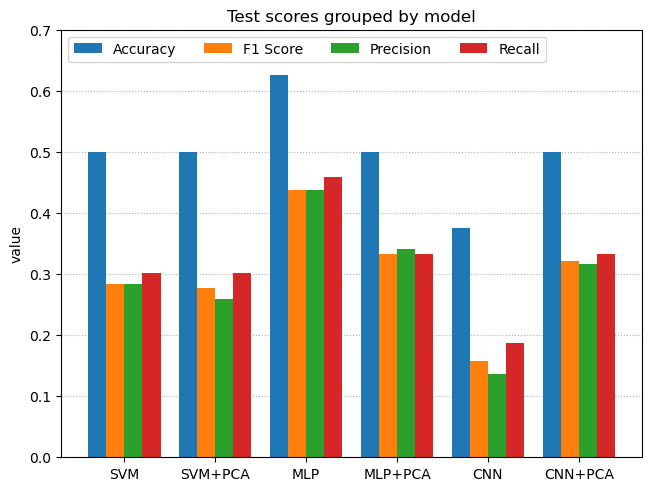

In [210]:
import matplotlib.pyplot as plt
import numpy as np

scores = {
    'Accuracy': eval_df.test_accuracy,
    'F1 Score': eval_df.test_f1_score,
    'Precision': eval_df.test_precision,
    'Recall': eval_df.test_recall,
}

models = eval_df.model

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in scores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=2)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('value')
ax.set_title('Test scores grouped by model')
ax.set_xticks(x + width + 0.1, models)
ax.grid(True, axis="y", linestyle=":", zorder=0)
ax.legend(loc='upper left', ncols=6)
ax.set_ylim(0, 0.7)

plt.show()

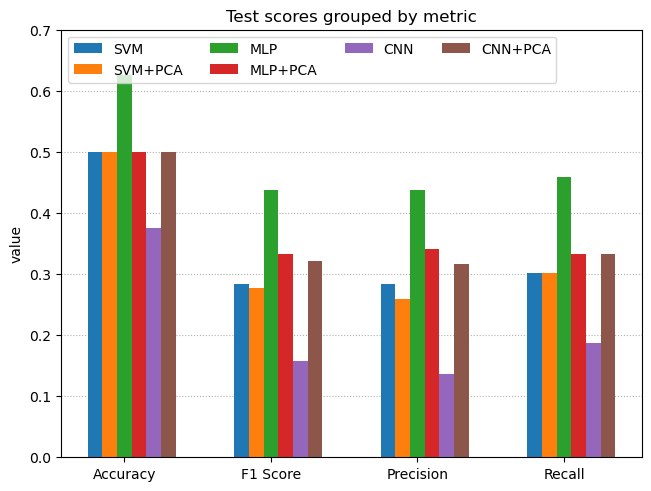

In [209]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ("Accuracy", "F1 Score", "Precision", "Recall")
scores = {
    eval_df.loc[0].to_numpy()[0]: list(eval_df.loc[0].to_numpy()[5:]),
    eval_df.loc[1].to_numpy()[0]: list(eval_df.loc[1].to_numpy()[5:]),
    eval_df.loc[2].to_numpy()[0]: list(eval_df.loc[2].to_numpy()[5:]),
    eval_df.loc[3].to_numpy()[0]: list(eval_df.loc[3].to_numpy()[5:]),
    eval_df.loc[4].to_numpy()[0]: list(eval_df.loc[4].to_numpy()[5:]),
    eval_df.loc[5].to_numpy()[0]: list(eval_df.loc[5].to_numpy()[5:]),
}

x = np.arange(len(metrics))  # the label locations
width = 0.1  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in scores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, zorder=2)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('value')
ax.set_title('Test scores grouped by metric')
ax.set_xticks(x + 0.1 + width, metrics)
ax.grid(True, axis="y", linestyle=":", zorder=0)
ax.legend(loc='upper left', ncols=4)
ax.set_ylim(0, 0.7)

plt.show()